In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from vanilla_vae import VanillaVAE
import wandb
import gc
import importlib
device = "cuda:0"

In [2]:
from PIL import Image

## Original image:

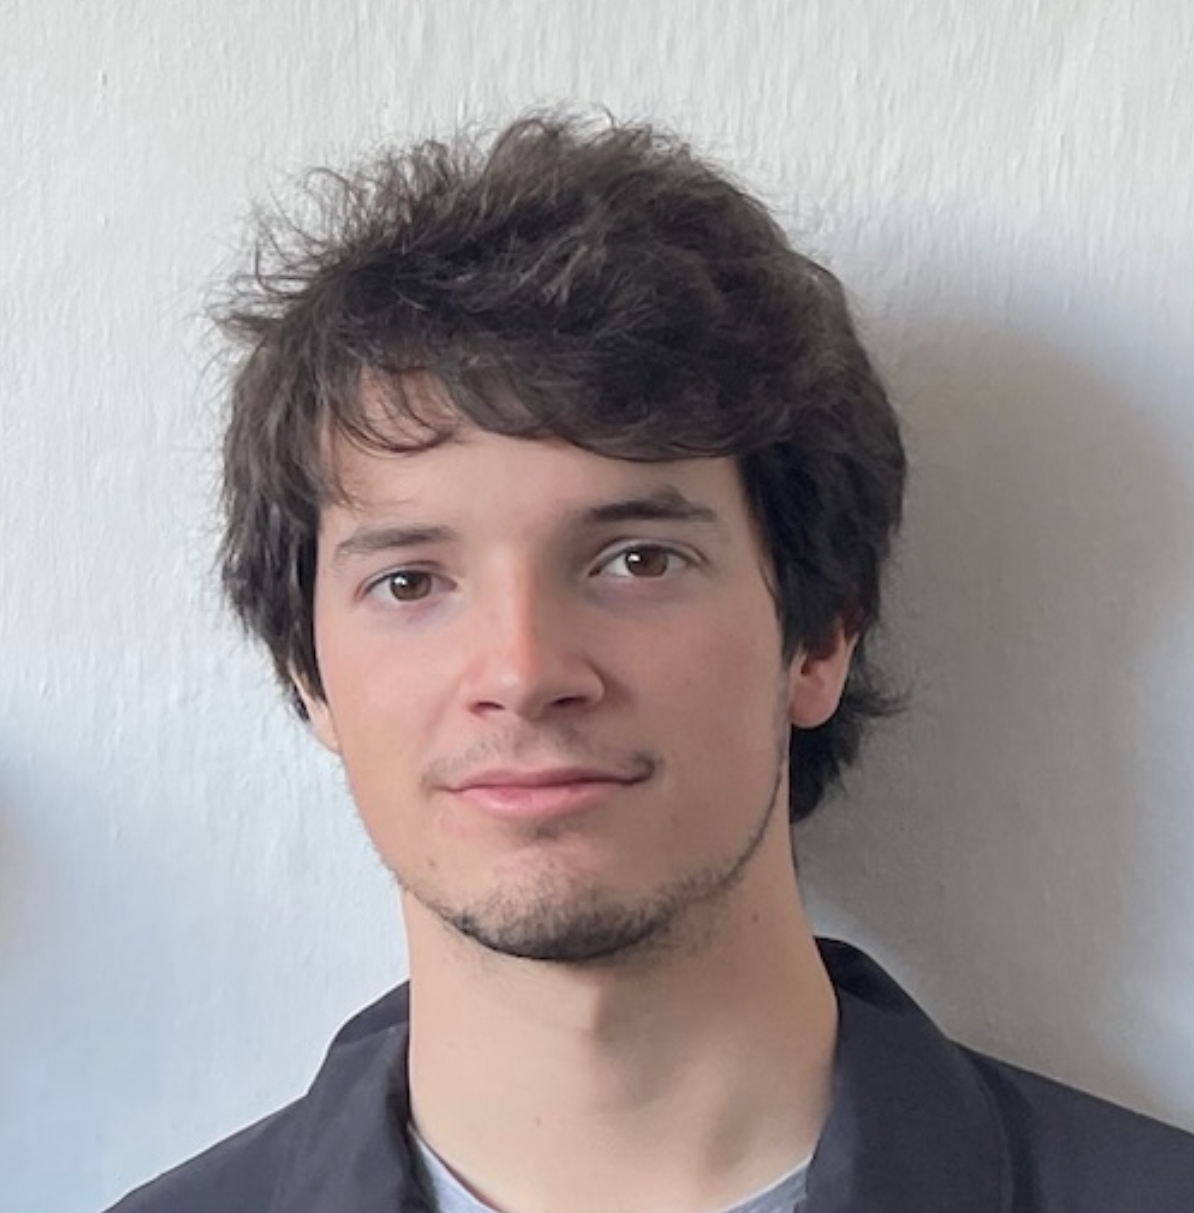

In [3]:
img_path = '../groupfaces/felipe.jpg'
img = Image.open(img_path)
img.show()

## VAE-w2w inversion:

### Step 1: Load VAE-w2w model

In [4]:
model_save_path = 'temp_vanilla_vae_latent512_beta0.01'

from vanilla_vae import VanillaVAE

latent_dim = 512
beta = 0.01
hidden_dims=[2048]

vae_w2w =  VanillaVAE(input_dim=99648, latent_dim=latent_dim, hidden_dims=[2048], beta=beta, batch_norm=False)
vae_w2w.load_state_dict(torch.load(os.path.join(model_save_path, "model.pt")))
vae_w2w = vae_w2w.to(device)
print(f"Model loaded from {model_save_path}")

Model loaded from temp_vanilla_vae_latent512_beta0.01


### Step 2: Invert

In [5]:
from utils import load_models
unet, diffusion_vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
import lora_VAEw2w
importlib.reload(lora_VAEw2w)
from lora_VAEw2w import LoRAw2wVAE
torch.cuda.empty_cache()
gc.collect()

49

In [7]:
from inversion_single_image import invert_single_image
from inversion import invert

In [8]:
epochs = 600

weight_dimensions_path = "../files/weight_dimensions.pt"
weight_dimensions = torch.load(weight_dimensions_path)

network = LoRAw2wVAE(vae_w2w, unet).to(device)

total params counted: 99648


In [9]:
wandb_proj_name = 'w2w-proj'
wandb_run_name = 'new_inversion-1'

wandb_name = {'proj': wandb_proj_name, 'run': wandb_run_name}

lr = 1e-6

inverted_network = invert(network=network, unet=unet, vae=diffusion_vae, text_encoder=text_encoder, tokenizer=tokenizer, 
                 prompt = "sks person", noise_scheduler = noise_scheduler, epochs=400, 
                 image_path = "../groupfaces/felipe/im/", 
                 mask_path = None, device = device, wandb_name=wandb_name, lr=lr)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fzmautner (fzmautner-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


 48%|████▊     | 193/400 [04:39<04:59,  1.45s/it]


KeyboardInterrupt: 

### Step 3: Display results

In [8]:
from vae_tester import VAESampleTester

torch.Size([1, 512])
torch.Size([1, 99648])


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Sample 0 results:


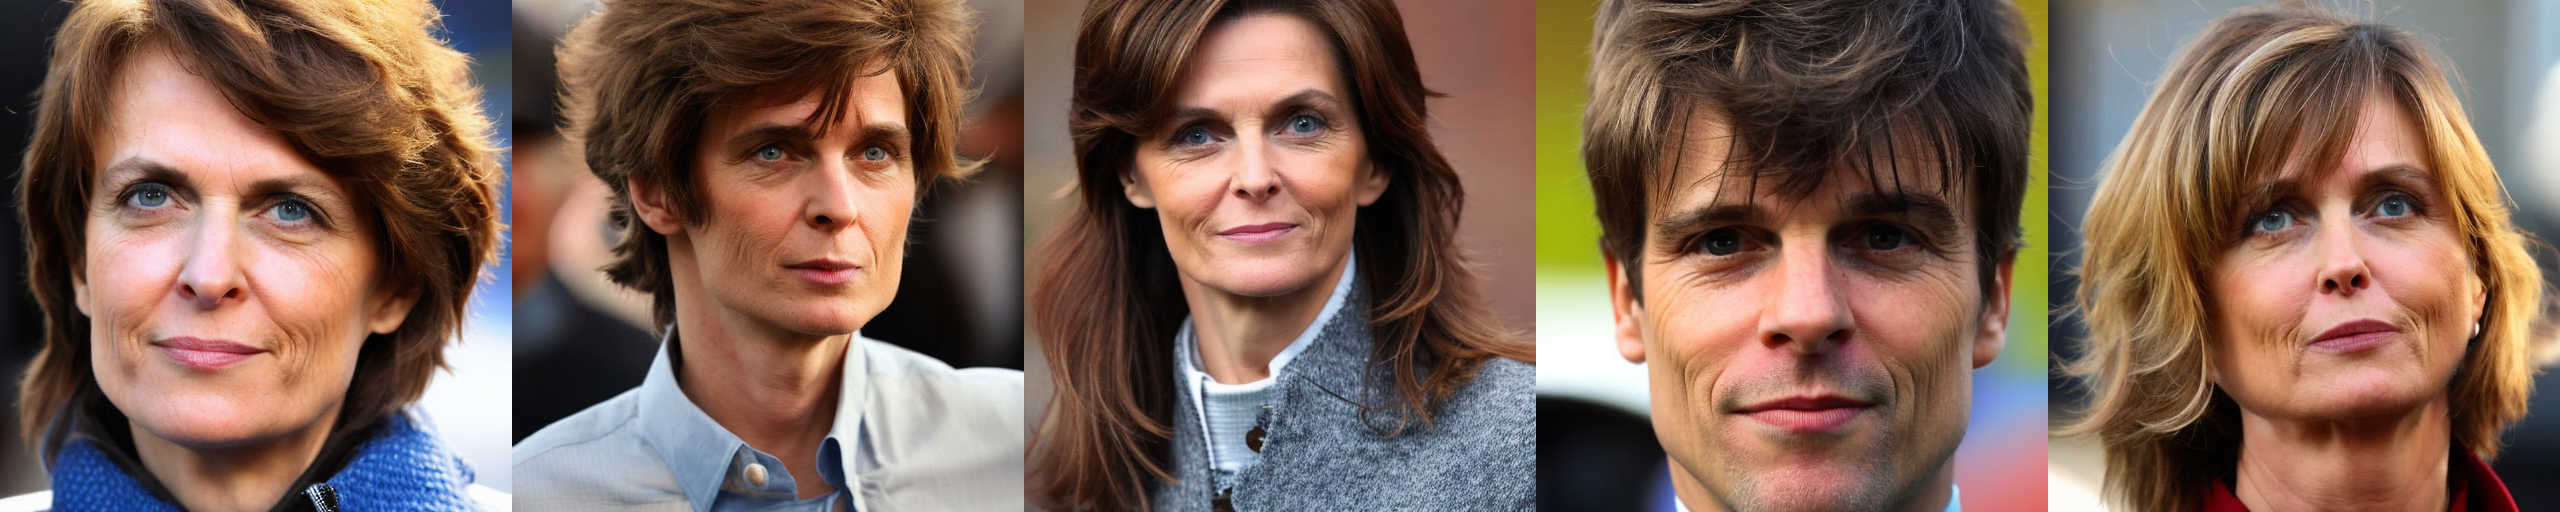

In [9]:
latent_model = network.z
print(latent_model.shape)
decoded = network.vae.decode(latent_model)
print(decoded.shape)
weight_dimensions = torch.load('../files/weight_dimensions.pt')

# Initialize the tester
tester = VAESampleTester(
    vae=vae_w2w,
    weight_dimensions=weight_dimensions,
    device=device
)

# Generate and display images from different samples
def compare_samples(sample_indices, n_images_per_sample=5):
    all_grids = []
    for idx in sample_indices:
        # Generate images
        images = tester.generate_from_sample(
            sample_idx=idx,
            vae_samples=decoded,
            n_images=n_images_per_sample
        )
        
        # Create grid
        grid = tester.create_image_grid(images)
        all_grids.append(grid)

        if wandb.run is not None:
            wandb.log({
                f"sample_{idx}_grid": wandb.Image(grid),
                "sample_index": idx
            })
        
        print(f"Sample {idx} results:")
        display(grid)
        print("\n")

        del images, grid

compare_samples([0])

## PCA-w2w inversion:

In [ ]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Step 1: Load PCA matrices

In [ ]:
from lora_w2w import LoRAw2w

mean = torch.load("../files/mean.pt").bfloat16().to(device)
std = torch.load("../files/std.pt").bfloat16().to(device)
v = torch.load("../files/V.pt").bfloat16().to(device)
weight_dimensions = torch.load("../files/weight_dimensions.pt")

### Step 2: Invert

### Step 3: Display results